# Extracting Semantic Information from Product Titles with MXNet, and Gluon

## Background


In the recent past, there has been tremendous amount of research on recommender systems. In particular, Deep Structured Semantic models attempt to capture information from attributes, such as product image, title and description. Extracting semantic information from these additional characteristics will solve the "cold start" problem in the space of recommender systems. In other words, when there is no much consumption history for a given user, a recommender system can propose products similar to the minimal products purchased by the user.

In this section, we will focus on how pre-trained word embeddings can be used in SageMaker to find books similar to the books that a user likes.

We will look at book ratings dataset from book crossing community. The dataset consists of ratings from over 280k book lovers.  More details on this dataset can be found at its [`Book-Crossing Dataset`](http://www2.informatik.uni-freiburg.de/~cziegler/BX/).

We are using conda mxnet p36 kernel

#### License

Improving Recommendation Lists Through Topic Diversification,
Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; Proceedings of the 14th International World Wide Web Conference (WWW '05), May 10-14, 2005, Chiba, Japan. To appear.

In [ ]:
#!pip freeze | grep onnx
!pip uninstall onnx
!pip install --upgrade onnx==1.1.1

In [6]:
!pip install --upgrade pip
!pip install mxnet-mkl 
!pip install --disable-pip-version-check  gluonnlp
!pip install nltk

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (19.0.1)


In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
#Import necessary modules
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt
import gluonnlp as nlp
import itertools
from nltk.tokenize import word_tokenize
import nltk
from sklearn.manifold import TSNE

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

### Read the book ratings dataset

In [12]:
fn = 'ClndBookRatings.csv'
#print(os.path.isfile(fn))

df_bkRatngs = pd.read_csv(fn, index_col=None)
df_bkRatngs.tail()

,ISBN,UserID,BookRating,BookTitle,user_ind,book_ind
169550,0312267177,57470,3,Catfish and Mandala : A Two-Wheeled Voyage thr...,9570,27072
169551,0882077155,78797,8,What happens when women pray (An input book),9582,27336
169552,0552996963,269076,7,The Visitation,9607,28296
169553,1588720284,223525,8,Why Your Life Sucks: And What You Can Do Abou...,9630,29236
169554,3789129402,264903,10,"Ronja, R�?¤ubertochter. ( Ab 10 J.).",9631,29240


In [13]:
df_bkRatngs.shape

(169555, 6)

The dataset includes information like:

- `ISBN`: Unique identifier of a book
- `UserID`: Unique identifier of a user rating the book
- `BookRating`: Rating of the book.
- `BookTitle`: Title of the book

In [20]:
df_bktitles = pd.DataFrame(df_bkRatngs['BookTitle'].unique(), columns=['BookTitle'])


In [21]:
df_bktitles.head()

,BookTitle
0,"Peace, Love and Healing: Bodymind Communicatio..."
1,Simple Abundance: A Daybook of Comfort and Joy
2,Summer Sisters
3,The Secret Life of Bees
4,Something More: Excavating Your Authentic Self


### Prepare words list from book titles

In [27]:
# get words from each title, remove words with punctuation marks, numbers, and lower case words

words = []

for i in df_bktitles['BookTitle']:
    tokens = word_tokenize(i)
    #print(tokens)
    # remove all tokens that are not alphabetic
    words.append([word.lower() for word in tokens if word.isalpha()])   # - this is list of lists

    
#remove empty strings from words list
words = list(filter(None, words))

In [28]:
len(words)
#words is a list of lists
#print(words)
#print(words[0])

26520

### Get word embedding from pre-trained fastText model

fastText is a library for learning of word embeddings and text classification created by Facebooks's AI Research Lab

In [30]:
#counter = nlp.data.count_tokens(itertools.chain.from_iterable([i.split() for i in reduced_df['product_title'].unique()]))

# vocab is a dictionary of key value pairs (value is number of times a word appears in the entire list of titles)
counter = nlp.data.count_tokens(itertools.chain.from_iterable(words))
vocab = nlp.Vocab(counter)

Vocab(size=16378, unk="<unk>", reserved="['<pad>', '<bos>', '<eos>']")


In [34]:
# Get the pretrained embeddings for each of the words
fasttext_simple = nlp.embedding.create('fasttext', source='wiki.simple')
vocab.set_embedding(fasttext_simple)

Embedding file wiki.simple.npz is not found. Downloading from Gluon Repository. This may take some time.


### Create embedding of a book title by averaging across individual word embeddings 

Start by instantiating an empty ndarray (multi dimensional)

In [35]:
title_arr_list = np.empty((0,300), dtype='f')

To create title embedding, average across individual word embeddings for each of the words in the title

In [38]:
for title in words:
    #print(title)
    #print(vocab.embedding[title])
    title_arr = ndarray.mean(vocab.embedding[title], axis=0, keepdims=True)
    #print(title_arr)
    title_arr_list = np.append(title_arr_list, title_arr.asnumpy(), axis=0)

In [39]:
title_arr_list.shape

(26520, 300)

In [73]:
title_arr_list[532]

array([ 0.15082675,  0.07728275, -0.0127375 , -0.2140505 ,  0.18744725,
        0.2502    , -0.13267276, -0.03032352,  0.0855845 ,  0.11788376,
        0.042479  ,  0.03986525,  0.14161225,  0.05404125, -0.00436475,
       -0.05686525, -0.07787325,  0.17517376, -0.13443975, -0.1014225 ,
        0.13224015,  0.10785392, -0.085875  , -0.0589975 , -0.08088601,
       -0.10210225,  0.05855925, -0.19277075, -0.02272875,  0.0552365 ,
        0.03794275, -0.0183535 , -0.06613176,  0.08222375, -0.004276  ,
        0.04773702, -0.01355603,  0.14621125,  0.032211  ,  0.142481  ,
        0.0625243 ,  0.02706825,  0.214765  ,  0.01536091,  0.08007172,
        0.0456765 , -0.08323663, -0.20152925, -0.01343451, -0.081581  ,
        0.099125  ,  0.01309706, -0.01951   ,  0.0362985 , -0.07072251,
        0.098306  , -0.03089475,  0.16851875,  0.0220125 ,  0.018746  ,
       -0.14541224,  0.110923  , -0.22055677, -0.12118   , -0.061845  ,
       -0.20832725, -0.28946075, -0.06058275, -0.00710525, -0.07

In [40]:
words[532]

['the', 'doll', 'house', 'sandman', 'book']

In [62]:
#np.isnan(title_arr_list).any()
#title_arr_list[np.isnan(title_arr_list)].shape
#arr1, arr2 = np.where(np.isnan(title_arr_list))

pd.DataFrame(arr1).to_csv('rownan.csv')

### Plot book title embeddings to locate similar books

T-distributed stochastic neighborhood embedding (t-SNE) is a machine learning algorithm for visualization. It is a non-linear dimensionality reduction technique

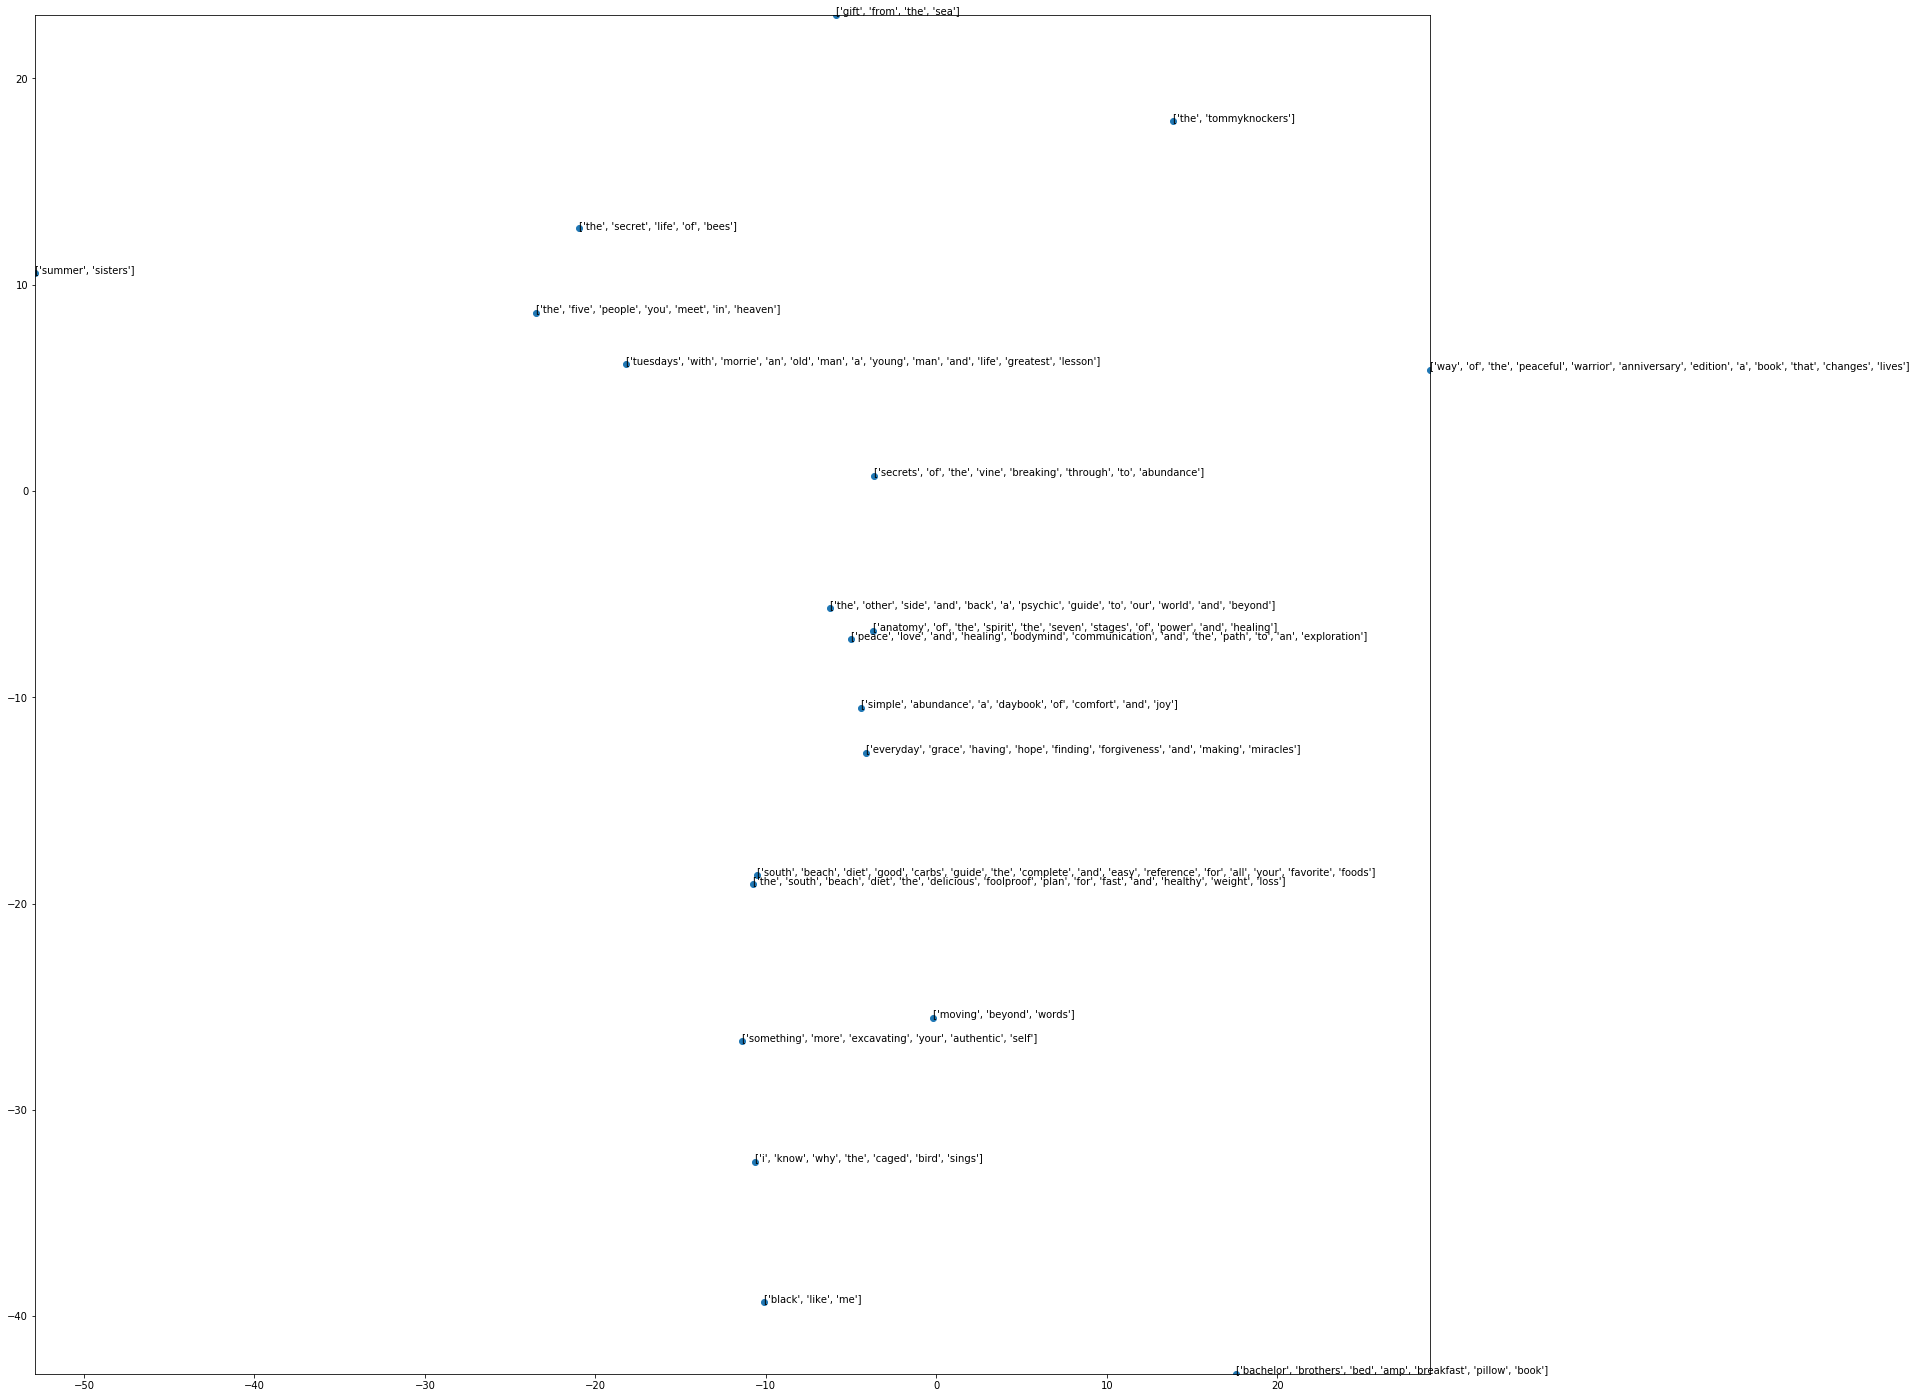

In [51]:
#show tsne plot

#word_labels = [words]

 # find tsne coords for 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(title_arr_list)

#select first 20 titles
word_labels = words[0:20]

x_coords = Y[0:20, 0]
y_coords = Y[0:20, 1]

# display scatter plot
plt.figure(figsize=(25, 25))
plt.scatter(x_coords, y_coords)

for label, x, y in zip(word_labels, x_coords, y_coords):
    #print("label x y", label, x, y)
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    #clip_on=True

plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()